In [26]:
# %% 0) Prosty model: tylko pogoda USA, pogoda Brazylia i ONI → target: cena soi (ZS=F)
# Wersja notebookowa, bez main(), minimalna inżynieria cech.

from __future__ import annotations
import os, time
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import yfinance as yf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.dpi"] = 140
YEARS_BACK = 20
END = pd.Timestamp.utcnow().floor("D")
START = END - pd.DateOffset(years=YEARS_BACK)

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "soy-simple-model/1.0"})

# (opcjonalny) fallback jeśli Yahoo nie działa:
PRICE_CSV_PATH = ""  # np. "data/soy_prices.csv"


In [27]:
# %% 1) Proste funkcje: Yahoo (ZS=F), NOAA ONI, Open-Meteo dla jednego punktu

# PATCH: bezpieczniejszy downloader Yahoo → zawsze zwraca Series i NIE używa .rename(<str>)
# Użyj tego zamiast wcześniejszej wersji fetch_yahoo_monthly.

def fetch_yahoo_monthly(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    import pandas as pd
    import yfinance as yf

    # Próba 1: interwał miesięczny (1mo)
    df = yf.download(
        ticker,
        start=start.date(),
        end=end.date(),
        auto_adjust=True,
        progress=False,
        interval="1mo",
        group_by="column",
        threads=True,
    )

    s = None
    if isinstance(df, pd.DataFrame) and not df.empty:
        if "Close" in df.columns:
            s = df["Close"]
        elif "Adj Close" in df.columns:
            s = df["Adj Close"]

    # Jeśli próba 1 się nie powiodła, spróbuj dzienne i zresampluj do MS
    if s is None or (hasattr(s, "empty") and s.empty):
        df = yf.download(
            ticker,
            start=start.date(),
            end=end.date(),
            auto_adjust=True,
            progress=False,
            interval="1d",
            group_by="column",
            threads=True,
        )
        if isinstance(df, pd.DataFrame) and not df.empty:
            if "Close" in df.columns:
                s = df["Close"]
            elif "Adj Close" in df.columns:
                s = df["Adj Close"]

            if s is not None and not s.empty:
                s = s.copy()
                s.index = pd.to_datetime(s.index).tz_localize(None)
                s = s.resample("MS").mean()

    # Upewnij się, że mamy Series (nie DataFrame)
    if isinstance(s, pd.DataFrame):
        # jeżeli z jakiegoś powodu to DataFrame z jedną kolumną
        if s.shape[1] >= 1:
            s = s.iloc[:, 0]
        else:
            s = pd.Series(dtype=float)

    if s is None:
        s = pd.Series(dtype=float)

    # Normalizacja indeksu miesięcznego (MS) i nazwy
    if not s.empty:
        s = s.copy()
        s.index = pd.to_datetime(s.index).tz_localize(None)
        # jeśli indeks nie jest MS, zrzuć do początku miesiąca
        s.index = s.index.to_period("M").to_timestamp(how="start")
        s = s.sort_index().dropna()
    s.name = ticker
    return s


def load_price_from_csv(path: str) -> pd.Series:
    if not path or not os.path.exists(path):
        return pd.Series(dtype=float, name="SOY")
    dfp = pd.read_csv(path)
    # heurystyka kolumn
    date_col = next((c for c in dfp.columns if str(c).lower() in {"date","time","dt"}), None)
    price_col = next((c for c in dfp.columns if str(c).lower() in {"close","price","value"}), None)
    if date_col is None or price_col is None:
        raise ValueError("CSV musi zawierać kolumny daty (Date/Time/Dt) i ceny (Close/Price/Value).")
    s = pd.Series(dfp[price_col].values, index=pd.to_datetime(dfp[date_col]), name="SOY")
    return s.sort_index().resample("MS").mean().dropna().rename("SOY")

def fetch_oni_noaa() -> pd.Series:
    # próba 1: gotowy ONI
    try:
        url1 = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
        r1 = SESSION.get(url1, timeout=30); r1.raise_for_status()
        rows = []
        for ln in r1.text.splitlines():
            p = ln.split()
            if len(p)==3 and p[0].isdigit() and p[1].isdigit():
                rows.append((int(p[0]), int(p[1]), float(p[2])))
        if rows:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m,_ in rows])
            return pd.Series([v for *_,v in rows], index=idx, name="ONI").sort_index()
    except Exception:
        pass
    # próba 2: NINO3.4 → 3M running mean
    try:
        url2 = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
        r2 = SESSION.get(url2, timeout=30); r2.raise_for_status()
        yrs, mons, n34 = [], [], []
        for ln in r2.text.splitlines():
            p = ln.split()
            if len(p)>=6 and p[0].isdigit() and p[1].isdigit():
                yrs.append(int(p[0])); mons.append(int(p[1])); n34.append(float(p[5]))
        if n34:
            idx = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in zip(yrs,mons)])
            s = pd.Series(n34, index=idx).sort_index()
            return s.rolling(3).mean().rename("ONI").dropna()
    except Exception:
        pass
    return pd.Series(dtype=float, name="ONI")

def fetch_openmeteo_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp,
                          retries: int = 5, timeout: int = 30) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": start.strftime("%Y-%m-%d"),
        "end_date": end.strftime("%Y-%m-%d"),
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": "UTC",
    }
    last = None
    for a in range(retries):
        try:
            r = SESSION.get(url, params=params, timeout=timeout); r.raise_for_status()
            d = r.json()["daily"]
            idx = pd.to_datetime(d["time"]).tz_localize(None)
            return pd.DataFrame({"temp_c": d["temperature_2m_mean"], "precip_mm": d["precipitation_sum"]}, index=idx)
        except Exception as e:
            last = e
            time.sleep((1.2**a) + np.random.rand()*0.3)
    return pd.DataFrame(columns=["temp_c","precip_mm"])


In [28]:
# %% 2) Minimalny indeks pogodowy soi (prosty, 0..100) i agregacja do miesięcy

def _lin(x, x0, x1, y0, y1):
    return y0 + (y1-y0) * ((x-x0)/(x1-x0))

def soybean_temp_score(temp_c: pd.Series) -> pd.Series:
    t = pd.to_numeric(temp_c, errors="coerce")
    s = pd.Series(0.0, index=t.index)
    s[(t <= 5) | (t >= 40)] = 0
    m = (t > 5)  & (t <= 10); s[m] = _lin(t[m], 5, 10, 0, 30)
    m = (t > 10) & (t < 20);  s[m] = _lin(t[m], 10, 20, 30, 80)
    m = (t >= 20)& (t <= 30); s[m] = _lin(t[m], 20, 30, 80, 100)
    m = (t > 30) & (t < 37);  s[m] = _lin(t[m], 30, 37, 100, 50)
    m = (t >= 37)& (t < 40);  s[m] = _lin(t[m], 37, 40, 50, 0)
    return s.clip(0,100)

def soybean_precip_score_daily(precip_mm: pd.Series, window_days: int = 30) -> pd.Series:
    p30 = pd.to_numeric(precip_mm, errors="coerce").rolling(window_days, min_periods=int(window_days*0.7)).sum()
    s = pd.Series(0.0, index=p30.index)
    m = (p30 >= 60) & (p30 < 90);  s[m] = _lin(p30[m], 60, 90, 0, 100)
    m = (p30 >= 90) & (p30 <=150); s[m] = 100
    m = (p30 > 150) & (p30 <=220); s[m] = _lin(p30[m],150,220, 100, 0)
    return s.clip(0,100)

def soybean_weather_index(temp_c: pd.Series, precip_mm: pd.Series, w_temp=0.6, w_precip=0.4) -> pd.Series:
    temp_c, precip_mm = temp_c.align(precip_mm, join="inner")
    ts = soybean_temp_score(temp_c)
    ps = soybean_precip_score_daily(precip_mm)
    return (w_temp*ts + w_precip*ps).clip(0,100)

def monthly_weather_index_for_point(lat: float, lon: float, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    df = fetch_openmeteo_point(lat, lon, start, end)
    if df.empty:
        return pd.Series(dtype=float)
    idx_daily = soybean_weather_index(df["temp_c"], df["precip_mm"])
    return idx_daily.resample("MS").mean().dropna()


In [29]:
# %% 3) Reprezentatywne punkty: USA (Corn Belt) i Brazylia (Mato Grosso)
# (po jednym punkcie na region, by ograniczyć 429)

USA_LATLON = (41.5868, -93.6250)   # Des Moines, Iowa (Corn Belt)
BRA_LATLON = (-12.9833, -57.9300)  # śr. Mato Grosso (soja BR)

WX_US = monthly_weather_index_for_point(*USA_LATLON, START, END).rename("WX_US")
WX_BR = monthly_weather_index_for_point(*BRA_LATLON, START, END).rename("WX_BR")

ONI = fetch_oni_noaa().rename("ONI")


In [30]:
# %% 4) Cena soi (ZS=F) — fallback do CSV jeśli potrzebny

SOY = fetch_yahoo_monthly("ZS=F", START, END).rename("SOY")
if (SOY is None) or SOY.dropna().empty:
    SOY = load_price_from_csv(PRICE_CSV_PATH)

# Na tym etapie można działać nawet bez SOY (np. analiza korelacji), ale do treningu będzie wymagane.


In [31]:
# %% 5) Zbiór danych: tylko WX_US, WX_BR, ONI i target SOY (t+1)
# proste cechy: bez yoy; LAG=0 oraz ewentualnie 1–2 (niewielkie)
# targetem będzie cena soi w następnym miesiącu (t+1)

df = pd.concat([SOY, WX_US, WX_BR, ONI], axis=1).sort_index()
# minimalne lags dla cech (pogoda/ONI)
for c in ["WX_US", "WX_BR", "ONI"]:
    if c in df.columns:
        df[f"{c}_lag1"] = df[c].shift(1)
        df[f"{c}_lag2"] = df[c].shift(2)

# target: SOY_t+1
df["SOY_t+1"] = df["SOY"].shift(-1)

# finalny zestaw cech (bez SOY bieżącego)
feature_cols = [c for c in df.columns if c not in ["SOY", "SOY_t+1"]]
df_ml = df.dropna(subset=feature_cols + ["SOY_t+1"]).copy()

# jeśli danych jest zbyt mało, skróć listę lagów lub wydłuż START


In [32]:
# %% 6) Trening: prosty model liniowy (StandardScaler + imputacja)
# split czasowy: ostatnie 20% = test

if len(df_ml) < 36:
    # zachowawczo wymagamy min. 3 lata
    raise RuntimeError("Za mało obserwacji do prostego modelu. Zmniejsz liczbę lagów lub wydłuż historię.")

split_idx = int(len(df_ml)*0.8)
train = df_ml.iloc[:split_idx]
test  = df_ml.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["SOY_t+1"]
X_test  = test[feature_cols]
y_test  = test["SOY_t+1"]

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), feature_cols)
])

model = Pipeline([
    ("pre", pre),
    ("lin", LinearRegression())
])

model.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['WX_US', 'WX_BR', 'ONI',
                                                   'WX_US_lag1', 'WX_US_lag2',
                                                   'WX_BR_lag1', 'WX_BR_lag2',
                                                   'ONI_lag1', 'ONI_lag2'])])),
                ('lin', LinearRegression())])

In [33]:
# %% 7) Predykcje i metryki
pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
def mape(a,b):
    m = a != 0
    return float(np.mean(np.abs((a[m]-b[m])/a[m]))*100)

metrics = {
    "train_MAE": float(np.mean(np.abs(y_train - pred_train))),
    "train_RMSE": rmse(y_train, pred_train),
    "train_MAPE_%": mape(y_train, pred_train),
    "test_MAE": float(np.mean(np.abs(y_test - pred_test))),
    "test_RMSE": rmse(y_test, pred_test),
    "test_MAPE_%": mape(y_test, pred_test),
}
metrics


{'train_MAE': 185.61750849211447,
 'train_RMSE': 241.22128546370513,
 'train_MAPE_%': 19.41596978062687,
 'test_MAE': 265.6677728722511,
 'test_RMSE': 306.055711666041,
 'test_MAPE_%': 19.457375351065036}

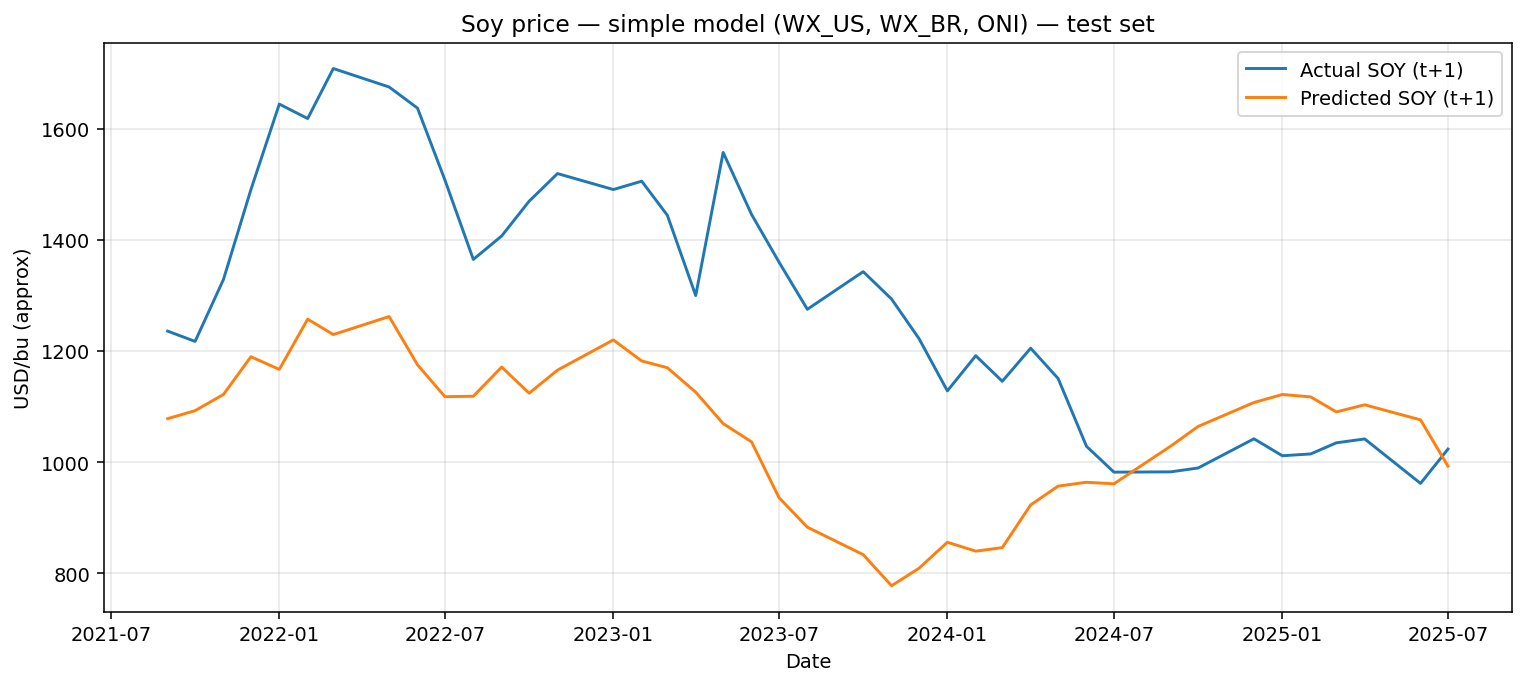

In [34]:
# %% 8) Wykres: rzeczywista vs prognoza (test, target t+1)
plt.figure(figsize=(11,5))
plt.plot(y_test.index, y_test.values, label="Actual SOY (t+1)")
plt.plot(y_test.index, pred_test, label="Predicted SOY (t+1)")
plt.title("Soy price — simple model (WX_US, WX_BR, ONI) — test set")
plt.xlabel("Date")
plt.ylabel("USD/bu (approx)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [35]:
# %% 9) (Opcjonalnie) predykcja na ostatni dostępny miesiąc (t+1)
# używa ostatniego wiersza cech (bez targetu), jeśli dostępny

last_feats = df[feature_cols].iloc[[-1]].dropna(axis=1)
# dopasuj kolumny (gdyby ostatni wiersz miał braki, predykcja może być niemożliwa)
missing = set(feature_cols) - set(last_feats.columns)
if missing:
    # jeśli brakuje niektórych kolumn, wstaw NaN – imputacja w pipeline sobie poradzi
    for c in missing: last_feats[c] = np.nan
    last_feats = last_feats[feature_cols]

next_month_pred = model.predict(last_feats)[0]
next_month_pred


1075.2779603487832